In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml, os

In [2]:
with open('models/yolov5n_nuscenes.yaml') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
anchors = np.array(data['anchors'])
anchors

array([[ 16,  30],
       [ 62,  45],
       [156, 198]])

[[ 16  30]
 [ 62  45]
 [156 198]]


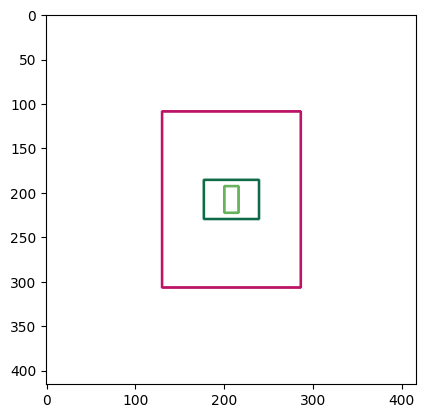

In [3]:
def draw_anchor(anchors, img_size=416):
    np.random.seed(42)
    bg = np.zeros((img_size, img_size, 3), np.uint8) + 255
    c = np.array(bg.shape[:2])//2
    def draw_box(a):
        p1, p2, = c - a//2, c + a//2
        cv2.rectangle(bg, p1, p2, [np.random.randint(0, 255) for x in range(3)], 2)
    for anchor in anchors:
        if len(anchor.shape) == 1:
            draw_box(anchor)
        else:
            for a in anchor:
                draw_box(a)
    plt.imshow(bg)
    plt.show()

print(anchors)
draw_anchor(anchors)

In [4]:
path = 'datasets/nuscenes/train/labels'
label_files = os.listdir(path)
boxes = []
for file in label_files:
    with open(f'{path}/{file}', 'r') as f:
        d = f.read().split('\n')[:-1]
        for obj in d:
            boxes += [np.array(obj.split(' ')[1:], dtype=np.float32).tolist()]
boxes = np.array(boxes)
boxes.shape

(268822, 4)

In [5]:
def box_iou_wh(wh1, wh2):
    inter_section = np.minimum(wh1, wh2)
    inter_area = np.prod(inter_section, axis=-1)
    union_area = np.prod(wh1, axis=-1) + np.prod(wh2, axis=-1) - inter_area
    return inter_area / (union_area + 1e-6)

In [6]:
def kmeans(wh, k):
    np.random.seed(42)
    np.random.shuffle(wh)
    n = wh.shape[0]
    last_cluster = np.zeros((n,), dtype=np.int64)
    clusters = wh[:k]

    while True:
        distances = 1 - box_iou_wh(wh[:, None], clusters)
        nearest = np.argmin(distances, axis=1)
        if np.all(last_cluster == nearest):
            break
        for idx in range(k):
            clusters[idx] = np.mean(wh[nearest == idx], axis=0)

        last_cluster = nearest
        
    prod = np.prod(clusters, axis=-1)
    idx = np.argsort(prod)
    return clusters[idx]

In [7]:
def ransac(wh, k, th=0.5, time=500):
    np.random.seed(42)
    inliner = wh[:k].copy()
    for i in range(time):
        np.random.shuffle(wh)
        clusters = wh[:k]
        distances = 1 - box_iou_wh(wh[:, None], clusters)
        min_distances = np.min(distances, -1)
        temp = wh[min_distances < th]
        if inliner.shape[0] < temp.shape[0]:
            inliner = temp.copy()
    print(f'{inliner.shape[0]/wh.shape[0]*100:.2f}%')
    return inliner

47.51%
[[ 21  41]
 [ 61  61]
 [206 307]]


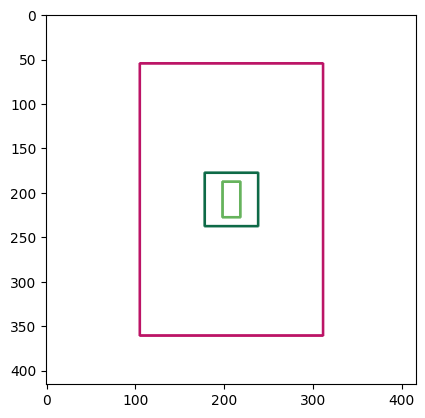

In [8]:
inliner = ransac(boxes[..., 2:], 10, 0.3)
anchors = np.ceil(kmeans(inliner, 3) * 640).astype(np.int32)
print(anchors)
draw_anchor(anchors)

88.62%
[[ 22  40]
 [ 62  73]
 [126 162]]


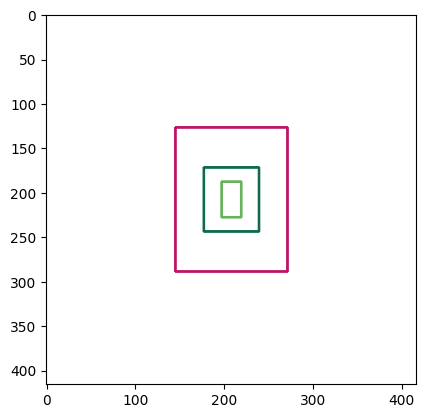

In [9]:
inliner = ransac(boxes[..., 2:], 10, 0.5)
anchors = np.ceil(kmeans(inliner, 3) * 640).astype(np.int32)
print(anchors)
draw_anchor(anchors)

98.96%
[[ 22  40]
 [ 69  84]
 [145 256]]


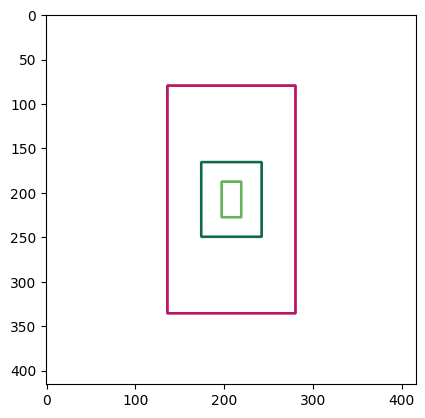

In [10]:
inliner = ransac(boxes[..., 2:], 10, 0.7)
anchors = np.ceil(kmeans(inliner, 3) * 640).astype(np.int32)
print(anchors)
draw_anchor(anchors)

[[ 22  42]
 [ 70  86]
 [146 265]]


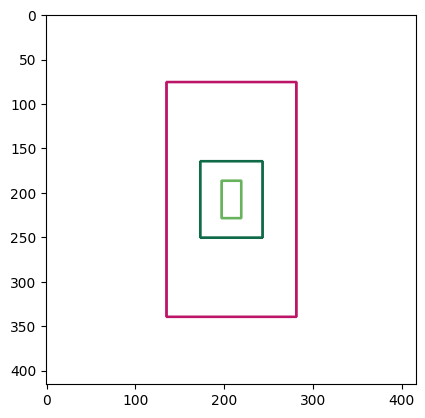

In [11]:
inliner = boxes[..., 2:].copy()
anchors = np.ceil(kmeans(inliner, 3) * 640).astype(np.int32)
print(anchors)
draw_anchor(anchors)

In [8]:
import cv2
import os

image_path = 'runs/detect/yolov5n_trained'
files = os.listdir(image_path)
images = []

image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

for file in image_files:
    img = cv2.imread(f'{image_path}/{file}')
    if img is not None:
        images.append(img)
    else:
        print(f'Warning: {file} could not be read.')

if not images:
    raise ValueError('No valid images found.')

size = images[-1].shape[:2][::-1]

video = cv2.VideoWriter(filename='video.mp4', 
                        fourcc=cv2.VideoWriter_fourcc(*'mp4v'), 
                        frameSize=size, 
                        fps=15)

for img in images:
    video.write(img)

video.release()
